# **Import Library**

In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile, os
import shutil 
import glob

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import np_utils

In [2]:
# input kaggle credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stanjk","key":"3f98d6c4e969d21915bc2a4c70ae9b70"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


Datasetnya mau pakai yang mana?
1. https://www.kaggle.com/lavaman151/plantifydr-dataset
2. https://www.kaggle.com/vipoooool/new-plant-diseases-dataset
3. https://data.mendeley.com/datasets/tywbtsjrjv/1

In [4]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [00:42<00:00, 86.9MB/s]
100% 2.70G/2.70G [00:42<00:00, 67.7MB/s]


# **Rename and Move Dataset Folder**

In [5]:
# run once
local_zip = 'new-plant-diseases-dataset.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/')

In [6]:
os.rename('/New Plant Diseases Dataset(Augmented)', '/plant')
os.rename('/plant/New Plant Diseases Dataset(Augmented)', '/plant/plant')

In [7]:
file = os.listdir('/plant/plant')
for fn in file:
  original = r'/plant/plant/{}'.format(fn)
  target = r'/plant/{}'.format(fn)
  shutil.move(original,target)

# **[Tomato]**

## **Only take tomato**

In [8]:
plant_use = ['Tomato']

for plant in plant_use:
  print(len(glob.glob("/plant/train/{}*".format(plant))))

10


In [9]:
base_dir = '/plant'
train_dir = os.path.join(base_dir, 'train_used_plant')
validation_dir = os.path.join(base_dir, 'valid_used_plant')

In [10]:
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

plant_use = ['Tomato']
for plant in plant_use:
  dir = glob.glob("/plant/train/{}*".format(plant))
  for i in range(len(dir)):
    original = dir[i]
    target = "/plant/train_used_plant/{}".format(original[13:])
    shutil.move(original,target)

In [11]:
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

plant_use = ['Tomato']
for plant in plant_use:
  dir = glob.glob("/plant/valid/{}*".format(plant))
  for i in range(len(dir)):
    original = dir[i]
    target = "/plant/valid_used_plant/{}".format(original[13:])
    shutil.move(original,target)

## **Visualization**

In [12]:
files = os.listdir(train_dir)
files

['Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___Bacterial_spot',
 'Tomato___Target_Spot',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold']

In [13]:
import matplotlib.image as mpimg
import random

numb_of_pic = 5
random.seed()

for fn in files:
  rand_F = []
  for i in range(numb_of_pic):
    rand_F.append(random.randint(0, len(os.listdir('{}/{}'.format(train_dir, fn)))))

  F_listdir = [os.listdir('{}/{}'.format(train_dir, fn))[i] for i in rand_F]
  F_listdir = [os.path.join('{}/{}'.format(train_dir, fn), fname) for fname in F_listdir]

  plt.figure(figsize=(15, 15))
  for i, image in enumerate(F_listdir):
    img = mpimg.imread(image)
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(fn)

Output hidden; open in https://colab.research.google.com to view.

## **Creating an input pipeline for Deep Learning using Keras Preprocessing**

In [27]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    color_mode = 'rgb', 
    batch_size = 100, 
    image_size = (224, 224),
    seed = 42,
    shuffle=True
)

Found 18345 files belonging to 10 classes.


In [28]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir, 
    color_mode = 'rgb', 
    batch_size = 100, 
    image_size = (224, 224),
    seed = 42,
    shuffle=True
)

Found 4585 files belonging to 10 classes.


In [46]:
class_names = validation_ds.class_names

In [51]:
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

### **Training**

In [70]:
# defining cnn
model_tomato = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(216, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation= 'softmax')
])

In [71]:
model_tomato.compile(
    optimizer=tf.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_tomato.fit(training_ds, validation_data = validation_ds, epochs = 20)

Epoch 1/20
184/184 [==============================] - 55s 295ms/step - loss: 2.9054 - accuracy: 0.5570 - val_loss: 0.6984 - val_accuracy: 0.7603
Epoch 2/20
184/184 [==============================] - 55s 293ms/step - loss: 0.5615 - accuracy: 0.8076 - val_loss: 0.4288 - val_accuracy: 0.8574
Epoch 3/20
184/184 [==============================] - 54s 292ms/step - loss: 0.3676 - accuracy: 0.8771 - val_loss: 0.3262 - val_accuracy: 0.8907
Epoch 4/20
184/184 [==============================] - 54s 290ms/step - loss: 0.2556 - accuracy: 0.9127 - val_loss: 0.3036 - val_accuracy: 0.9049
Epoch 5/20
184/184 [==============================] - 54s 290ms/step - loss: 0.1897 - accuracy: 0.9349 - val_loss: 0.2463 - val_accuracy: 0.9213
Epoch 6/20
184/184 [==============================] - 54s 289ms/step - loss: 0.1482 - accuracy: 0.9489 - val_loss: 0.2410 - val_accuracy: 0.9291
Epoch 7/20
184/184 [==============================] - 54s 291ms/step - loss: 0.1209 - accuracy: 0.9599 - val_loss: 0.2728 - val_ac

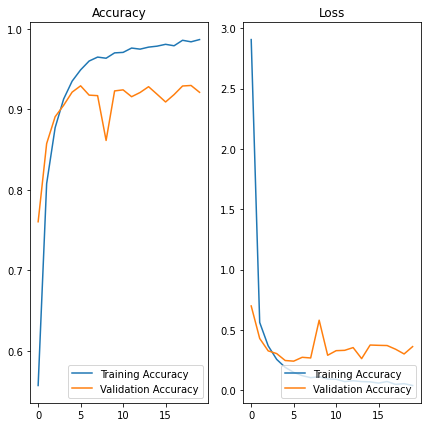

In [72]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Accuracy')
plt.title('Loss')
plt.legend(loc='lower right')
plt.show()

**Model Evaluation**

In [73]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in validation_ds.take(1):
    predictions = model_tomato.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [76]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  pred = model_tomato.predict(images, batch_size=10)
  classes = np.argmax(pred)

  plt.imshow(img)
  plt.show()
  
  print('\nPic name: {}'.format(fn))
  print('Prediction: {}'.format(class_names[classes]))

Output hidden; open in https://colab.research.google.com to view.

## **Creating an input pipeline for Deep Learning using TensorFlow**

In [ ]:
# Create Dataframe

def create_info_df(path):
    list_plants = []
    list_dir = os.listdir(path) 
    for plant in list_dir:
        url = path +'/'+plant
        for img in os.listdir(url):
            list_plants.append([*plant.split('___'), url+'/'+img, plant])

    # Create DataFrame
    df = pd.DataFrame(list_plants, columns=['Plant', 'Category', 'Path','Plant___Category'])
    df['Disease'] = df.Category.apply(lambda x: 0 if x=='healthy' else 1)

    return df

# Get Validation and Training DF
potato_train_info = create_info_df(train_dir)
potato_valid_info = create_info_df(validation_dir)

In [ ]:
potato_train_info

,Plant,Category,Path,Plant___Category,Disease
0,Tomato,Spider_mites Two-spotted_spider_mite,/plant/train_used_plant/Tomato___Spider_mites ...,Tomato___Spider_mites Two-spotted_spider_mite,1
1,Tomato,Spider_mites Two-spotted_spider_mite,/plant/train_used_plant/Tomato___Spider_mites ...,Tomato___Spider_mites Two-spotted_spider_mite,1
2,Tomato,Spider_mites Two-spotted_spider_mite,/plant/train_used_plant/Tomato___Spider_mites ...,Tomato___Spider_mites Two-spotted_spider_mite,1
3,Tomato,Spider_mites Two-spotted_spider_mite,/plant/train_used_plant/Tomato___Spider_mites ...,Tomato___Spider_mites Two-spotted_spider_mite,1
4,Tomato,Spider_mites Two-spotted_spider_mite,/plant/train_used_plant/Tomato___Spider_mites ...,Tomato___Spider_mites Two-spotted_spider_mite,1
...,...,...,...,...,...
18340,Tomato,Leaf_Mold,/plant/train_used_plant/Tomato___Leaf_Mold/132...,Tomato___Leaf_Mold,1
18341,Tomato,Leaf_Mold,/plant/train_used_plant/Tomato___Leaf_Mold/f48...,Tomato___Leaf_Mold,1
18342,Tomato,Leaf_Mold,/plant/train_used_plant/Tomato___Leaf_Mold/052...,Tomato___Leaf_Mold,1
18343,Tomato,Leaf_Mold,/plant/train_used_plant/Tomato___Leaf_Mold/af7...,Tomato___Leaf_Mold,1


In [ ]:
unique_plant_cat = np.unique(potato_train_info['Plant___Category'].to_numpy())

In [ ]:
# Creation of constants
IMG_SIZE = 64
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
OUTPUT_SHAPE = 10
NUM_EPOCHS = 20

In [ ]:
## FUNCTION UTILS - Prepare Data and Dataset ##

def create_img_df(df_info, frac=0.1, random_state=42):
    return df_info.sample(frac=frac, random_state=random_state).reset_index()

def create_train_val_df(valid_info, train_info, frac=0.1, random_state=42):
    """
    Create Train and validation dataframe
    Return:
      - train dataframe
      - validation dataframe
    """
    valid_df = create_img_df(valid_info, frac, random_state)
    train_df = create_img_df(train_info, frac, random_state)
    
    # Get information shape
    valid_img_cnt,train_img_count = valid_df.shape[0], train_df.shape[0]
    total = valid_img_cnt + train_img_count
    # Print information
    print(f'Total images (frac={frac}): ', total)
    print(f"Training ({train_img_count}): {train_img_count/total*100:.2f}% - Validation ({valid_img_cnt}): {valid_img_cnt/total*100:.2f}%")
     
    return train_df, valid_df


def get_bool_label(labels):
    # Create a variable of all Labels
    plant_cat_labels = labels.to_numpy()
    # Create Boolean label list
    bool_plant_cat = [unique_plant_cat == plant_cat for plant_cat in plant_cat_labels]
    # return array
    return bool_plant_cat
    
# Prepare Data
def prepare_data(train_df, valid_df):
    """
    Get Train and Validation Data Frame and return X_train, X_val, y_train, y_val
    """
    # create images (X) arrays
    X_train = train_df['Path']
    X_val = valid_df['Path']
    
    # create labels (y) arrays
    y_train = get_bool_label(train_df['Plant___Category'])
    y_val = get_bool_label(valid_df['Plant___Category'])
    
    print('Shape: ',X_train.shape, X_val.shape, len(y_train), len(y_val))
    
    return X_train, X_val, y_train, y_val
    
# Dataset function utils

# Decode and load image
def decode_img(path, img_shape=IMG_SHAPE):
    """
    Read image from `path`, and convert the image to a 3D tensor
    return resized image.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)/255
    img = tf.image.resize(img, img_shape)
    return img

# Configure dataset for performance
def configure_for_performance(ds):
    #ds = ds.cache()
    ds = ds.batch(batch_size)
    #ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create a function to get Dataset
def create_dataset(X, y=None, valid_data=False, test_data=False, img_shape=IMG_SHAPE):
    """
    Create Dataset from Images (X) and Labels (y)
    Shuffles the data if it's training data but doesn't shuffle if it validation data.
    Also accepts test data as input (no labels).
    Return Dataset 
    """
    print("Creating data set...")
    # If test data, there is no labels
    if test_data:       
        print("Creating test data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X))
        dataset = dataset.map(lambda x: decode_img(x, img_shape), num_parallel_calls=AUTOTUNE)
        dataset = configure_for_performance(dataset)
    # If Valid_data - we don't need to shuffle
    elif valid_data:
        print("Creating Valid data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        dataset = dataset.map(lambda x, y: [decode_img(x, img_shape), y], num_parallel_calls=AUTOTUNE)
        dataset = configure_for_performance(dataset)
    else:
        print("Creating Training data batches...")
        dataset = tf.data.Dataset.from_tensor_slices((X, y))
        dataset = dataset.map(lambda x, y: [decode_img(x, img_shape), y], num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(buffer_size=len(X))
        dataset = configure_for_performance(dataset)
           
    print(dataset.element_spec)

    return dataset

In [ ]:
X_train, X_val, y_train, y_val = prepare_data(potato_train_info, potato_valid_info)

Shape:  (18345,) (4585,) 18345 4585


In [ ]:
dataset_train = create_dataset(X_train, y_train, img_shape=IMG_SHAPE)
# Validation Dataset - not shuffle
dataset_val = create_dataset(X_val, y_val, valid_data=True, img_shape=IMG_SHAPE)
# Verify length of both datasets
len(dataset_train), len(dataset_val)

Creating data set...
Creating Training data batches...
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None))
Creating data set...
Creating Valid data batches...
(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.bool, name=None))


(574, 144)

### **Training**

In [ ]:
# defining cnn
model_tomato_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation= 'softmax')
])

In [ ]:
model_tomato_2.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_2 = model_tomato_2.fit(x=dataset_train, validation_data=dataset_val, epochs=10)

Epoch 1/10
574/574 [==============================] - 31s 24ms/step - loss: 1.3643 - accuracy: 0.4984 - val_loss: 0.6633 - val_accuracy: 0.7583
Epoch 2/10
574/574 [==============================] - 30s 24ms/step - loss: 0.5823 - accuracy: 0.7926 - val_loss: 0.4310 - val_accuracy: 0.8478
Epoch 3/10
574/574 [==============================] - 30s 24ms/step - loss: 0.4128 - accuracy: 0.8512 - val_loss: 0.3759 - val_accuracy: 0.8709
Epoch 4/10
574/574 [==============================] - 30s 24ms/step - loss: 0.3107 - accuracy: 0.8911 - val_loss: 0.2988 - val_accuracy: 0.8944
Epoch 5/10
574/574 [==============================] - 30s 24ms/step - loss: 0.2519 - accuracy: 0.9105 - val_loss: 0.2587 - val_accuracy: 0.9095
Epoch 6/10
574/574 [==============================] - 29s 24ms/step - loss: 0.2143 - accuracy: 0.9222 - val_loss: 0.2993 - val_accuracy: 0.8949
Epoch 7/10
574/574 [==============================] - 30s 24ms/step - loss: 0.1848 - accuracy: 0.9350 - val_loss: 0.2470 - val_accuracy:

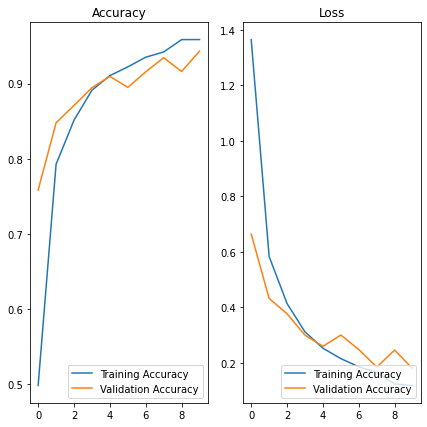

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Accuracy')
plt.title('Loss')
plt.legend(loc='lower right')
plt.show()

**Model Evaluation**

In [ ]:
# Useful functions to evaluate model

# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """
    Turns an array of prediction probabilities into a label.
    """
    return unique_plant_cat[np.argmax(prediction_probabilities)]

# Create a function to unbatch a batch dataset
def unbatchify(batch_data):
    """
    Take batch data and return unbatch data (separate arrays of images and labels) in a form of a tuple of lists
    """
    img = []
    lbl = []
    for image, label in batch_data.unbatch().as_numpy_iterator():
        img.append(image*255)
        lbl.append(get_pred_label(label))

    return img,lbl

# Show images and prediction rate
def show_img_and_prediction(model, nb_img=9):
    # Get predictions
    predictions = model.predict(dataset_val)
    # Get Validation datset images and true labels
    imgs, labels = unbatchify(dataset_val)
    # Get 10 random images in the validation dataset
    img_rdm = np.random.randint(0, len(imgs), nb_img)

    plt.figure(figsize=(20,12))
    for idx, i in enumerate(img_rdm):
        color = 'red'

        plt.subplot(3,3,idx+1)
        plt.imshow(imgs[i].astype('uint8'))
        plt.xticks([])
        plt.yticks([])

        if get_pred_label(predictions[i]) == labels[i]:
            color = 'green'

        plt.title('Pred({}) : {} - {:2.0f}%'.format(i, get_pred_label(predictions[i]), np.max(predictions[i])*100), color=color)
        plt.xlabel('Real: {}'.format(labels[i]));    

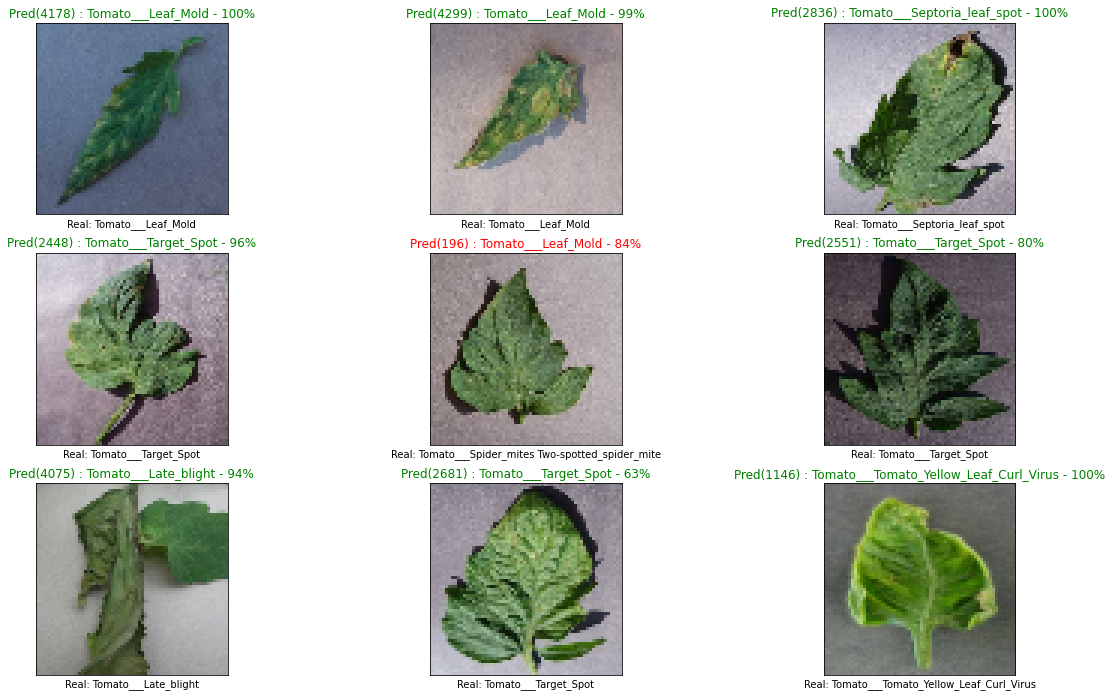

In [ ]:
show_img_and_prediction(model_tomato)

In [ ]:
from google.colab import files
from keras.preprocessing import image
from skimage import color
from skimage import io
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(64, 64))
  x = image.img_to_array(img)

  # x = x / 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model_tomato_2.predict(images, batch_size=10)
  classes = np.argmax(classes)
  label = os.listdir(train_dir)
  
  print('\nPic name: {}'.format(fn))
  print('Prediction: {}'.format(label[classes]))

Saving 26-500x375.jpg to 26-500x375 (1).jpg

Pic name: 26-500x375.jpg
Prediction: Tomato___Bacterial_spot


## **Saved Model**

In [77]:
model_tomato.save('model_tomato_1.h5')

In [78]:
!pip install tensorflowjs
!tensorflowjs_converter \
    --input_format=keras \
    model_tomato_1.h5 \
    /tmp/my_tfjs_model_tomato

     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 112kB 9.3MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0
2021-06-02 09:59:08.375464: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [79]:
!zip -r /tmp/tomato_1.zip /tmp/my_tfjs_model_tomato

  adding: tmp/my_tfjs_model_tomato/ (stored 0%)
  adding: tmp/my_tfjs_model_tomato/group1-shard11of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard14of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard16of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard19of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard18of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard10of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard15of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard4of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard2of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/model.json (deflated 85%)
  adding: tmp/my_tfjs_model_tomato/group1-shard12of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard8of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tomato/group1-shard1of19.bin (deflated 7%)
  adding: tmp/my_tfjs_model_tom

In [87]:
from google.colab import files
files.download("/tmp/tomato_1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
tomato_prediction = tf.keras.models.load_model('model_tomato_1.h5')

In [85]:
from keras.preprocessing import image

img = image.load_img('target-spot-tomato.jpg', target_size=(224, 224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

img = np.vstack([img])

pred = tomato_prediction.predict(img.tolist())
confidence = '%.3f'%(np.amax(pred)*100)
disease = class_names[np.argmax(pred)]

In [86]:
confidence, disease

('95.475', 'Tomato___Target_Spot')